In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_after_gen.csv',)
test = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/test_after_gen.csv')
train_target = pd.read_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_target.csv')

## Алгоритмическое заполнение пропущенных значений:

Начнём с содержательной части, связанной с обучением различных моделей для заполнения пропущенных данных на основе имеющейся информации.

Перейдём к рассмотрению аудитории сервиса: так как более 40% выборки составляют люди с неуказанным гендером, проиллюстрируем два графика. Первый из них отражает зависимости частоты прослушиваний от пола и возраста юзера.

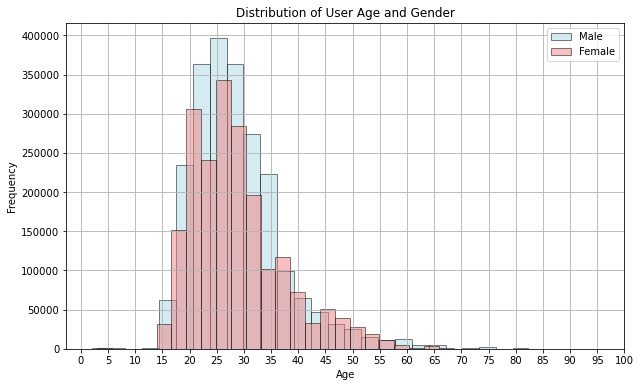

In [3]:
plt.figure(figsize=(10, 6))
train['bd'][(train['gender'] == 'male') & (train['bd'] > 0) & (train['bd'] <= 100)].plot(kind='hist', bins=30, color='lightblue', edgecolor='black', alpha=0.5, label='Male')
train['bd'][(train['gender'] == 'female') & (train['bd'] > 0) & (train['bd'] <= 100)].plot(kind='hist', bins=30, color='lightcoral', edgecolor='black', alpha=0.5, label='Female')
plt.title('Distribution of User Age and Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(range(0, 101, 5))
plt.grid(True)
plt.show()

In [6]:
train.gender.fillna("Unknown", inplace = True)
test.gender.fillna("Unknown", inplace = True)

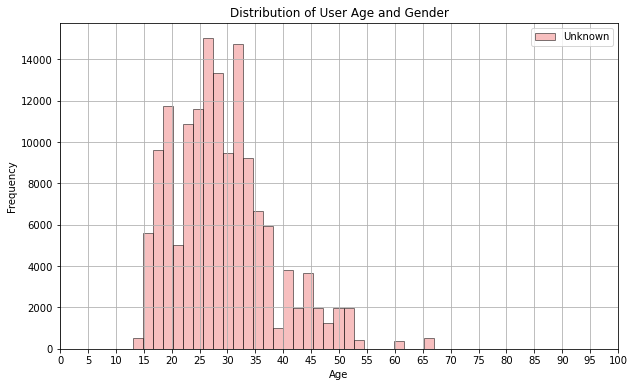

In [7]:
plt.figure(figsize=(10, 6))
train['bd'][(train['gender'] == 'Unknown') & (train['bd'] > 0) & (train['bd'] <= 100)].plot(kind='hist', bins=30, color='lightcoral', edgecolor='black', alpha=0.5, label='Unknown')
plt.title('Distribution of User Age and Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(range(0, 101, 5))
plt.grid(True)
plt.show()

Заметим, что распределение мужчин, женщин и лиц без указанного гендера почти идентично. Зная это, попробуем научить алгоритм классификации обучить по всем прочим признакам понимать какой юзер перед ним - мужчина или женщина, и заполним соответствующие пропуски в данных

In [8]:
train_known = train[train['gender'] != 'Unknown']
X_train = train_known.drop(columns=['gender'])
y_train = train_known['gender']

numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf.fit(X_train, y_train)

train_unknown = train[train['gender'] == 'Unknown']
X_train_unknown = train_unknown.drop(columns=['gender'])
train_pred = clf.predict(X_train_unknown)

train.loc[train['gender'] == 'Unknown', 'gender'] = train_pred

test_known = test[test['gender'] != 'Unknown']
X_test = test_known.drop(columns=['gender'])
y_test = test_known['gender']

clf.fit(X_test, y_test)

test_unknown = test[test['gender'] == 'Unknown']
X_test_unknown = test_unknown.drop(columns=['gender'])
test_pred = clf.predict(X_test_unknown)

test.loc[test['gender'] == 'Unknown', 'gender'] = test_pred


Посмотрим получившиеся распределение на наличие выбросов; сравним с прежду полученным.

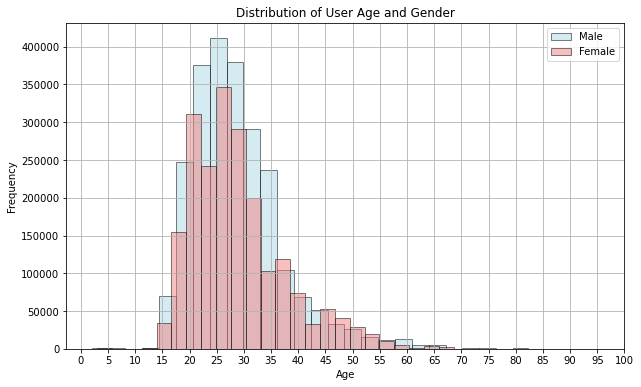

In [9]:
plt.figure(figsize=(10, 6))
train['bd'][(train['gender'] == 'male') & (train['bd'] > 0) & (train['bd'] <= 100)].plot(kind='hist', bins=30, color='lightblue', edgecolor='black', alpha=0.5, label='Male')
train['bd'][(train['gender'] == 'female') & (train['bd'] > 0) & (train['bd'] <= 100)].plot(kind='hist', bins=30, color='lightcoral', edgecolor='black', alpha=0.5, label='Female')
plt.title('Distribution of User Age and Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(range(0, 101, 5))
plt.grid(True)
plt.show()

## Эксперимент

## Заполнение остальных пропущенных значений:

Основная часть пропущенных значений содержится в категориальных переменных - было бы странно заполнять пропущенные значения в artist_name, например, самым встречающимся. Заполним основную часть строками со значением "Unknown", но где-то оставим 0 (если неизвестна длина песни и язык)

In [10]:
train.source_system_tab.fillna("Unknown", inplace = True)
test.source_system_tab.fillna("Unknown", inplace = True)

train.source_screen_name.fillna("Unknown", inplace = True)
test.source_screen_name.fillna("Unknown", inplace = True)

train.source_type.fillna("Unknown", inplace = True)
test.source_type.fillna("Unknown", inplace = True)

train.song_length.fillna(0, inplace = True)
test.song_length.fillna(0, inplace = True)

train.genre_ids.fillna("Unknown", inplace = True)
test.genre_ids.fillna("Unknown", inplace = True)

train.artist_name.fillna("Unknown", inplace = True)
test.artist_name.fillna("Unknown", inplace = True)

train.composer.fillna("Unknown", inplace = True)
test.composer.fillna("Unknown", inplace = True)

train.lyricist.fillna("Unknown", inplace = True)
test.lyricist.fillna("Unknown", inplace = True)

train.language.fillna(0, inplace = True)
test.language.fillna(0, inplace = True)

train.name.fillna("Unknown", inplace = True)
test.name.fillna("Unknown", inplace = True)

train.song_year.fillna("Unknown", inplace = True)
test.song_year.fillna("Unknown",inplace = True)

train.gender.fillna("Unknown",inplace = True)
test.gender.fillna("Unknown",inplace = True)

train.registered_via.fillna("Unknown",inplace = True)
test.registered_via.fillna("Unknown",inplace = True)

## Сохраняем результаты обработки датасета

In [11]:
train.to_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_for_train.csv', index=False)
test.to_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/test_for_train.csv', index=False)
train_target.to_csv('/Users/artemshevchenko/Desktop/ВК_рек/kkbox-music-recommendation-challenge/train_target_for_train.csv', index=False)